# 물류 최적경로

In [1]:
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

### 물류 데이터

In [2]:
!curl https://raw.githubusercontent.com/StillWork/data/master/supply.zip \
    -o supply.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48374  100 48374    0     0  17003      0  0:00:02  0:00:02 --:--:-- 16997--:--     0


In [5]:
!unzip -o supply.zip

Archive:  supply.zip
  inflating: tbl_factory.csv         
  inflating: __MACOSX/._tbl_factory.csv  
  inflating: tbl_transaction.csv     
  inflating: __MACOSX/._tbl_transaction.csv  
  inflating: tbl_warehouse.csv       
  inflating: __MACOSX/._tbl_warehouse.csv  
  inflating: rel_cost.csv            
  inflating: __MACOSX/._rel_cost.csv  
  inflating: demand.csv              
  inflating: __MACOSX/._demand.csv   
  inflating: network_pos.csv         
  inflating: __MACOSX/._network_pos.csv  
  inflating: network_weight.csv      
  inflating: __MACOSX/._network_weight.csv  
  inflating: supply.csv              
  inflating: __MACOSX/._supply.csv   
  inflating: trans_cost.csv          
  inflating: __MACOSX/._trans_cost.csv  
  inflating: trans_route_new.csv     
  inflating: __MACOSX/._trans_route_new.csv  
  inflating: trans_route_pos.csv     
  inflating: __MACOSX/._trans_route_pos.csv  
  inflating: trans_route.csv         
  inflating: __MACOSX/._trans_route.csv  


In [7]:
import pandas as pd

# 공장 데이터 
factories = pd.read_csv("tbl_factory.csv", index_col=0)
print(factories.shape)
factories

(8, 3)


,FCName,FCDemand,FCRegion
FCID,,,
FC00001,서울공장,28,북부
FC00002,수원공장,29,북부
FC00003,인천공장,31,북부
FC00004,대전공장,25,북부
FC00005,대구공장,21,남부
FC00006,광주공장,30,남부
FC00007,부산공장,25,남부
FC00008,울산공장,16,남부


In [8]:
# 창고 데이터
warehouses = pd.read_csv("tbl_warehouse.csv", index_col=0)
print(warehouses.shape)
warehouses

(6, 3)


,WHName,WHSupply,WHRegion
WHID,,,
WH00001,판교창고,35,북부
WH00002,용인창고,41,북부
WH00003,수원창고,42,북부
WH00004,대전창고,60,남부
WH00005,대구창고,72,남부
WH00006,광주창고,65,남부


In [9]:
# 비용 테이블
# Cost: 창고에서 공장으로 운송 비용이 얼마인지를 표시 (단위: 만원)
cost = pd.read_csv("rel_cost.csv", index_col=0)
print(cost.shape)
cost[:10]

(24, 3)


,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8
3,FC00001,WH00003,1.5
4,FC00002,WH00001,0.9
5,FC00002,WH00002,0.8
6,FC00002,WH00003,1.6
7,FC00003,WH00001,1.2
8,FC00003,WH00002,1.3
9,FC00003,WH00003,1.5


In [10]:
# 운송 실적 테이블 (시점, 장소, 운송량)
trans = pd.read_csv("tbl_transaction.csv", index_col=0)
print(trans.shape)
trans[:5]

(4000, 4)


,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30


In [19]:
# 4000개의 샘플이 있는, 운송실적 테이블에 비용 데이터 추가
# 운송 실적을 기준으로

join_data = pd.merge(trans, cost, left_on=["ToFC","FromWH"], right_on=["FCID","WHID"], how="left")
print(join_data.shape)
join_data.head()

(4000, 7)


,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8


In [20]:
# 위 데이터에 공장정보를 추가
# "ToFC"와 "FCID" 사용
join_data = pd.merge(join_data, factories, left_on="ToFC", right_on="FCID", how="left")
join_data[:3]

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,대전공장,25,북부
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,부산공장,25,남부
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,광주공장,30,남부


In [21]:
# 창고정보도 추가
join_data = pd.merge(join_data, warehouses, left_on="FromWH", right_on="WHID", how="left")
join_data[:3]

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,대전공장,25,북부,수원창고,42,북부
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,부산공장,25,남부,광주창고,65,남부
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,광주공장,30,남부,대전창고,60,남부


In [22]:
# 컬럼 표시 순서 정리
# 불필요한 FCID는 삭제
join_data = join_data[["TransactionDate","Quantity","Cost","ToFC","FCName","FCDemand","FromWH","WHName","WHSupply","WHRegion"]]
join_data[:3]

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,대전공장,25,WH00003,수원창고,42,북부
1,2019-01-01 06:12:42,19,1.3,FC00007,부산공장,25,WH00006,광주창고,65,남부
2,2019-01-01 06:32:32,31,0.9,FC00006,광주공장,30,WH00004,대전창고,60,남부


In [25]:
# 북부와 남부 데이터 분리
north = join_data.loc[join_data["WHRegion"]=="북부"]
north[:3]

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,대전공장,25,WH00003,수원창고,42,북부
3,2019-01-01 07:17:06,18,1.6,FC00002,수원공장,29,WH00003,수원창고,42,북부
4,2019-01-01 07:52:18,30,0.8,FC00001,서울공장,28,WH00002,용인창고,41,북부


In [24]:
# 남부 데이터 추출
south = join_data.loc[join_data["WHRegion"]=="남부"]
south[:3]

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,부산공장,25,WH00006,광주창고,65,남부
2,2019-01-01 06:32:32,31,0.9,FC00006,광주공장,30,WH00004,대전창고,60,남부
5,2019-01-01 08:56:09,31,0.3,FC00005,대구공장,21,WH00005,대구창고,72,남부


### 운송량, 비용

In [26]:
# 지사별 비용합계
print("북부지사 총비용: " + str(north["Cost"].sum()) + "만원")
print("남부지사 총비용: " + str(south["Cost"].sum()) + "만원")

북부지사 총비용: 2189.3만원
남부지사 총비용: 2062.0만원


In [29]:
# 지사별 총 운송개수
print("북부지사의 총부품 운송개수: " + str(north["Quantity"].sum()) + "개")
print("남부지사의 총부품 운송개수: " + str(south["Quantity"].sum()) + "개")

북부지사의 총부품 운송개수: 49146개
남부지사의 총부품 운송개수: 50214개


In [30]:
# 부품 1개당 운송비용
tmp = (north["Cost"].sum() / north["Quantity"].sum()) * 10000
print("북부지사의 부품 1개당 운송 비용: " + str(int(tmp)) + "원")
tmp = (south["Cost"].sum() / south["Quantity"].sum()) * 10000
print("남부지사의 부품 1개당 운송 비용: " + str(int(tmp)) + "원")

북부지사의 부품 1개당 운송 비용: 445원
남부지사의 부품 1개당 운송 비용: 410원


- 남부 지사의 비용이 적다

In [27]:
# 비용을 지사별로 집계
cost_chk = pd.merge(cost, factories, on="FCID", how="left")
cost_chk

,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,FC00001,WH00001,0.4,서울공장,28,북부
1,FC00001,WH00002,0.8,서울공장,28,북부
2,FC00001,WH00003,1.5,서울공장,28,북부
3,FC00002,WH00001,0.9,수원공장,29,북부
4,FC00002,WH00002,0.8,수원공장,29,북부
5,FC00002,WH00003,1.6,수원공장,29,북부
6,FC00003,WH00001,1.2,인천공장,31,북부
7,FC00003,WH00002,1.3,인천공장,31,북부
8,FC00003,WH00003,1.5,인천공장,31,북부
9,FC00004,WH00001,0.8,대전공장,25,북부


In [28]:
# 평균 운송 비용
print("북부지사의 평균 운송 비용：" + str(cost_chk["Cost"].loc[cost_chk["FCRegion"]=="북부"].mean()) + "원")
print("남부지사의 평균 운송 비용：" + str(cost_chk["Cost"].loc[cost_chk["FCRegion"]=="남부"].mean()) + "원")

북부지사의 평균 운송 비용：1.075원
남부지사의 평균 운송 비용：1.05원


# 네트워크 가시화

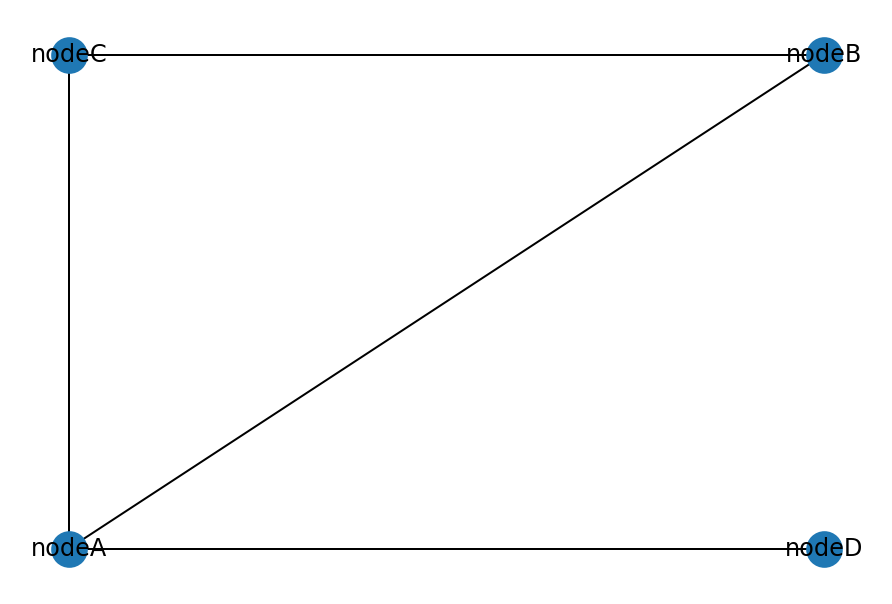

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

# 그래프 객체 생성．
G=nx.Graph()

# 노드 설정
G.add_node("nodeA")
G.add_node("nodeB")
G.add_node("nodeC")
G.add_node("nodeD")

# 엣지 설정
G.add_edge("nodeA","nodeB")
G.add_edge("nodeA","nodeC")
G.add_edge("nodeB","nodeC")
G.add_edge("nodeA","nodeD")

# 좌표 설정
pos={}
pos["nodeA"]=(0,0)
pos["nodeB"]=(1,1)
pos["nodeC"]=(0,1)
pos["nodeD"]=(1,0)

# 그리기
nx.draw(G,pos, with_labels=True)
plt.show()

### 경로에 가중치 부여

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# 위치 좌표와 가중치(비용) 데이터 불러오기
df_p = pd.read_csv('network_pos.csv')
df_w = pd.read_csv('network_weight.csv')

In [34]:
df_p # 위치 

,A,B,C,D,E
0,0,0,2,2,1
1,0,2,0,2,1


In [35]:
df_w # 가중치

,A,B,C,D,E
0,0.639921,0.143353,0.944669,0.521848,0.000000
1,0.264556,0.000000,0.456150,0.568434,0.000000
2,0.617635,0.612096,0.616934,0.943748,0.000000
3,0.000000,0.000000,0.697631,0.060225,0.666767
4,0.670638,0.210383,0.000000,0.315428,0.000000


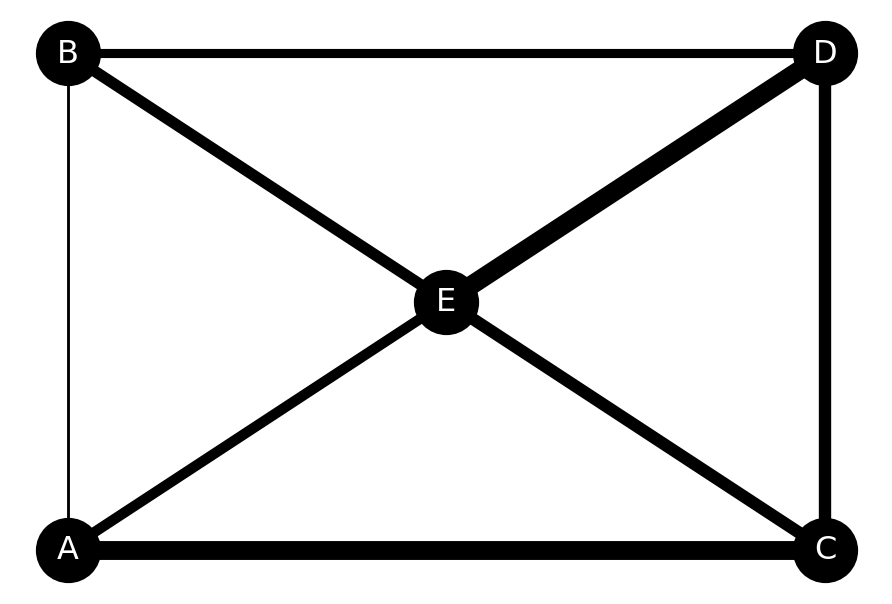

In [36]:
# 엣지 가중치 리스트화
size = 10
edge_weights = []
for i in range(len(df_w)):
    for j in range(len(df_w.columns)):
        edge_weights.append(df_w.iloc[i][j]*size)

# 그래프 객체 생성
G = nx.Graph()
for i in range(len(df_w.columns)):
    G.add_node(df_w.columns[i])

# 엣지 설정
for i in range(len(df_w.columns)):
    for j in range(len(df_w.columns)):
        G.add_edge(df_w.columns[i],df_w.columns[j])

# 좌표 설정
pos = {}
for i in range(len(df_w.columns)):
    node = df_w.columns[i]
    pos[node] = (df_p[node][0],df_p[node][1])

# 가중치에 비례하여 선의 굵기 조절
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, 
        node_color='k', font_color='w', width=edge_weights)
plt.show()

### 운송 경로 및 운송량 정보

In [38]:
# 운송 경로 및 운송량 데이터
df_tr = pd.read_csv('trans_route.csv', index_col="공장")
df_tr

,F1,F2,F3,F4
공장,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


### 운송경로정보로 네트워크 가시화

In [39]:
# 위치 좌표 정보
df_pos = pd.read_csv('trans_route_pos.csv')
df_pos

,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


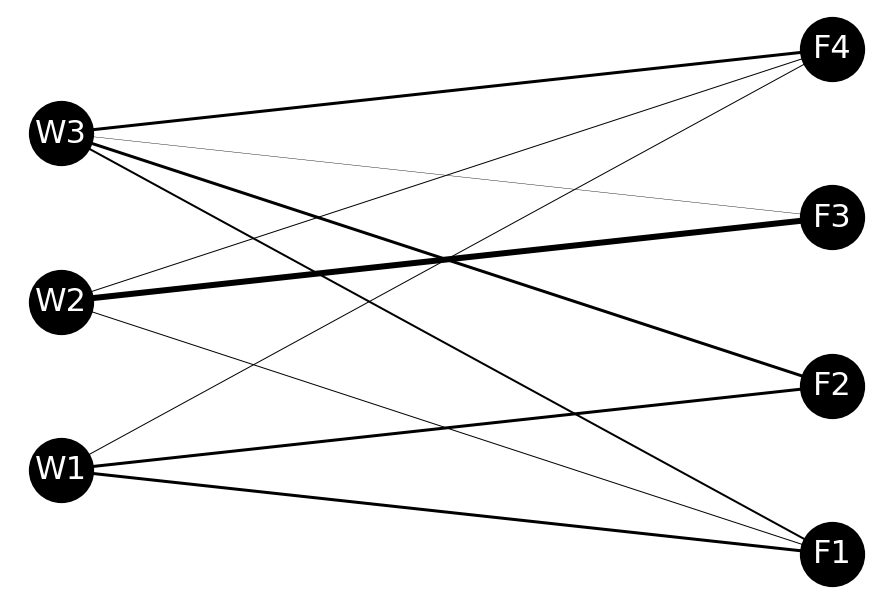

In [41]:
# 그래프 객체 생성
G = nx.Graph()
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 엣지 설정 및 가중치 리스트화
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            # 엣지 추가
            G.add_edge(df_pos.columns[i],df_pos.columns[j])
            # 엣지 가중치 추가
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)
                
# 좌표 설정
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])
    
# 그리기
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, 
        node_color='k', font_color='w', width=edge_weights)
plt.show()

# 최적화 문제
- 목적 함수 정의
- 제약 조건 정의
- 제약 조건을 만족하면서 목적함수를 최적화 하는 조합을 선택

- 여기서는, 운송 비용을 낮출 효율적인 운송 경로를 찾는 것이 목적

### 운송비용함수 정의
- (운송량 x 운송비용)의 총합

In [42]:
import pandas as pd

# 운송 경로, 창고-공장간 운송 비용 데이터
df_tr = pd.read_csv('trans_route.csv', index_col="공장")
df_tc = pd.read_csv('trans_cost.csv', index_col="공장")

# 운송 비용 계산 함수
def trans_cost(df_tr,df_tc):
    cost = 0
    for i in range(len(df_tc.index)):
        for j in range(len(df_tr.columns)):
            cost += df_tr.iloc[i][j]*df_tc.iloc[i][j]
    return cost

print("총 운송 비용:"+str(trans_cost(df_tr,df_tc)))

총 운송 비용:1493


### 제약조건
- 각 창고에서는 공급량의 제한
- 각 공장에서는 필요한 최소량

In [43]:
import pandas as pd

# 공급량 제한 및 필요 최소량 데이터
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

In [44]:
df_demand

,F1,F2,F3,F4
0,28,29,31,25


In [45]:
df_supply

,W1,W2,W3
0,35,41,42


- 각 창고에서 출하되는 부품의 수와 각 창고의 공급 한계량을 비교하여 출하량이 공급 한계를 넘는지 검토 (제약조건)
- 각 공장으로 운반되는 부품의 수와 각 공장에 대한 수요량을 비교하여 공장에서 제조된 제품의 수가 수요량을 만족시키는지 검토 (제약조건)

In [46]:
# 공급측 제약조건
for i in range(len(df_supply.columns)):
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    print(str(df_supply.columns[i])+"부터의 운송량:"+str(temp_sum)+" (공급한계:"+str(df_supply.iloc[0][i])+")")
    if temp_sum<=df_supply.iloc[0][i]:
        print("공급한계 범위내")
    else:
        print("공급한계 초과. 운송경로 재계산 필요")

# 수요측 제약조건
for i in range(len(df_demand.columns)):
    temp_sum = sum(df_tr[df_demand.columns[i]])
    print(str(df_demand.columns[i])+"으로 운송량:"+str(temp_sum)+" (수요량:"+str(df_demand.iloc[0][i])+")")
    if temp_sum>=df_demand.iloc[0][i]:
        print("수요량을 만족시키고있음")
    else:
        print("수요량을 만족시키지 못하고 있음. 운송경로 재계산 필요")


W1부터의 운송량:35 (공급한계:35)
공급한계 범위내
W2부터의 운송량:40 (공급한계:41)
공급한계 범위내
W3부터의 운송량:42 (공급한계:42)
공급한계 범위내
F1으로 운송량:30 (수요량:28)
수요량을 만족시키고있음
F2으로 운송량:30 (수요량:29)
수요량을 만족시키고있음
F3으로 운송량:32 (수요량:31)
수요량을 만족시키고있음
F4으로 운송량:25 (수요량:25)
수요량을 만족시키고있음


### 운송경로를 변경, 운송비용 함수 변화 확인
- W1 --> F4의 공급량을 줄이고
- W2 --> F4의 공급량을 늘인 경우

In [48]:
import pandas as pd
import numpy as np

# 데이터 불러오기
df_tr_new = pd.read_csv('trans_route_new.csv', index_col="공장")
df_tr_new

,F1,F2,F3,F4
공장,,,,
W1,15,15,0,0
W2,5,0,30,10
W3,10,15,2,15


In [49]:
# 참고
df_tr

,F1,F2,F3,F4
공장,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


In [50]:
# 총 운송비용 재계산 
print("총 운송 비용(변경 후):"+str(trans_cost(df_tr_new,df_tc)))

# 제약조건 계산함수
# 수요측
def condition_demand(df_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag
            
# 공급측
def condition_supply(df_tr,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum<=df_supply.iloc[0][i]:
            flag[i] = 1
    return flag

print("수요조건 계산결과:"+str(condition_demand(df_tr_new,df_demand)))
print("공급조건 계산결과:"+str(condition_supply(df_tr_new,df_supply)))

총 운송 비용(변경 후):1428
수요조건 계산결과:[1. 1. 1. 1.]
공급조건 계산결과:[1. 0. 1.]


- 총 비용은 줄어드나 W2의 공급한계를 넘은 것을 알 수 있다. 즉 제약조건을 만족시키지 못함
- 이러한 작업을 자동으로 최적화 하는 것이 필요하다 (LP)